In [1]:
import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.optimize as opt
from scipy.stats import levy_stable, multivariate_normal
from plotnine import *

In [2]:
def sg_sample(n, alpha, Sigma, components = False):
    levy_stable.parameterization = 'S1'
    G = multivariate_normal.rvs(mean = np.zeros(Sigma.shape[0]), cov = Sigma, size=n)
    W = levy_stable.rvs(alpha = alpha/2, beta = 1, loc=0, scale = np.cos(np.pi*alpha/4)**(2/alpha), size = n)
    X = np.sqrt(W).reshape(-1,1)*G

    if components:
        return [X, W, G]

    return X

def generate_matrix(d, variances=None):
    """
    Generate a random d-dimensional covariance matrix.

    Parameters:
    d (int): Dimension of the covariance matrix.
    variances (np.ndarray, optional): A vector of variances for each dimension.
                                       If not provided, a correlation matrix is returned.

    Returns:
    np.ndarray: A d x d covariance matrix or a correlation matrix if variances are not provided.
    """
    correlation_matrix = generate_correlation_matrix(d)
    
    if variances is not None:
        covariance_matrix = np.diag(np.sqrt(variances)) @ correlation_matrix @ np.diag(np.sqrt(variances))
        return covariance_matrix
    
    return correlation_matrix


In [3]:
# Define parameters for simulation
alpha = 1.7
cov = np.array([[1, 0.4], [0.4, 1]])

In [4]:
X = sg_sample(100, alpha, cov)

<positron-console-cell-4>:5: RuntimeWarning: invalid value encountered in sqrt


In [19]:
# NOTE: NEED TO REPARAMETERIZE COV = 1/2*cov
X = multivariate_normal.rvs(mean = np.zeros(cov.shape[0]), cov = cov, size=200) 

In [8]:
def e_i(x, mu, Sigma, alpha):
    Sigma_inv = np.linalg.inv(Sigma)
    k = int(np.round(min(168, 168/alpha)))
    d = Sigma.shape[0]
    D_range = (sp.gamma((k*alpha+alpha+2)/2)*sp.gamma((k*alpha+alpha+2+d)/2)/((k+1)*sp.gamma((k*alpha+2)/2)*sp.gamma((k*alpha+2+d)/2)))**(2/alpha)
    D = np.einsum('ij,jk,ik->i', x - mu, Sigma_inv, x - mu) # Equivalent to (X-mu).T @ Sigma_inv @ (X-mu) for each row

    # Initialize the result array
    e_posterior = np.zeros(x.shape[0])

    # Loop over each realization in X
    for i in range(x.shape[0]):
        if D[i] > D_range:
            num = sum(
                (-1)**j / sp.gamma(j + 1) *
                sp.gamma((j * alpha + 2) / 2) *
                sp.gamma((j * alpha + d + 2) / 2) *
                np.sin(j * np.pi * alpha / 2) *
                (D[i])**(-(j * alpha + d + 2) / 2)
                for j in range(1, k + 1)
            )
            denom = sum(
                (-1)**j / sp.gamma(j + 1) *
                sp.gamma((j * alpha + 2) / 2) *
                sp.gamma((j * alpha + d) / 2) *
                np.sin(j * np.pi * alpha / 2) *
                (D[i])**(-(j * alpha + d) / 2)
                for j in range(1, k + 1)
            )
            e_posterior[i] = num / denom
        else:
            M = 4000
            W = levy_stable.rvs(alpha=alpha/2, beta=1, loc=0, scale=np.cos(np.pi*alpha/4)**(2/alpha), size=M)
            num = np.sum(W**(-d/2 - 1) * np.exp(-0.5 * D[i] / W))
            denom = np.sum(W**(-d/2) * np.exp(-0.5 * D[i] / W))
            e_posterior[i] = num / denom

    return e_posterior



In [457]:
# Generate arbitrary d-dimensional correlation matrix to simulate from
cov = generate_matrix(100)

# Simulate elliptically symmetric stable random variables
S = sg_sample(1000, alpha, Sigma = cov, components=True)
x = S[0] # Extract stable component of output

# Run EM updates for num_iter iterations
num_iter = 200
n = x.shape[0]
d = x.shape[1]

# Instantiate values
Sigma_0 = np.eye(d)
mu_0 = np.zeros(d)
alpha = 1.7 # Replace with univariate MLE

for _ in range(num_iter):
    # E-Step
    e_posterior = e_i(x, mu_0, Sigma_0, alpha)

    # M-Step
    # Update location estimate
    mu_0 = (e_posterior.T @ x) / np.sum(e_posterior)

    # Instantiate values
    Sigma_0 = np.zeros((d, d))

    # Estimate conditional convariance matrix estimate
    for i in range(n):
        diff = x[i] - mu_0  # Compute x_i - mu^(t)
        Sigma_0 += np.outer(diff, diff)*e_posterior[i] / np.sum(e_posterior)

    #Sigma_0 /= n  # Divide by n

<positron-console-cell-457>:5: RuntimeWarning: overflow encountered in scalar multiply
<positron-console-cell-457>:5: RuntimeWarning: invalid value encountered in scalar divide


In [22]:
e_posterior = e_i(x, np.zeros(d), cov, alpha)

/Users/jonas.elmerraji/.pyenv/versions/3.10.13/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 21 rows containing missing values.


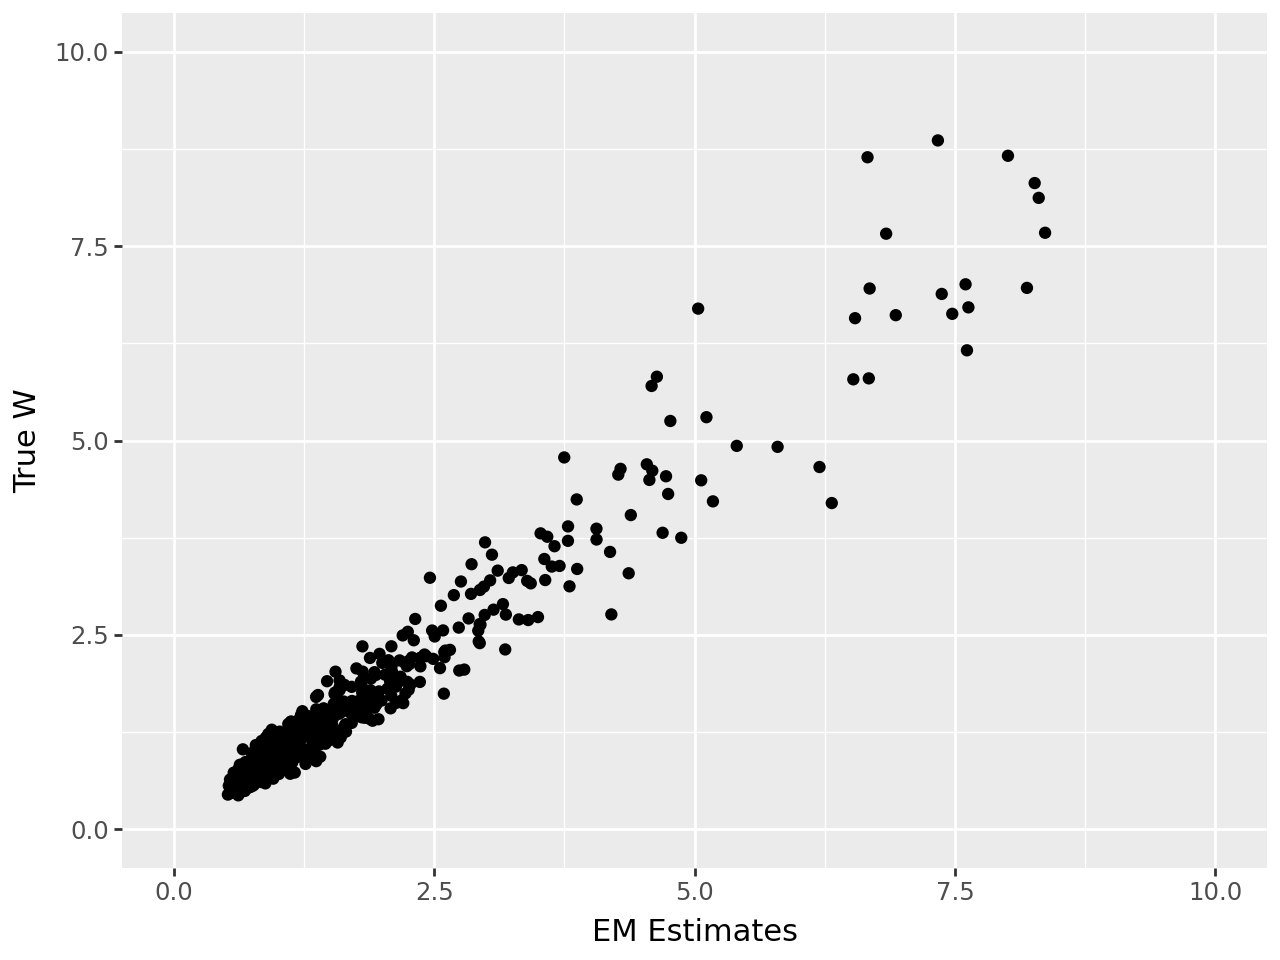

In [460]:
# Combine the arrays into a pandas DataFrame
df = pd.DataFrame({
    'EM Estimates': 1/e_posterior,
    'True W': S[1]
})

(
    ggplot(df, aes("EM Estimates", "True W")) + geom_point() + scale_x_continuous(limits = [0,10]) + scale_y_continuous(limits = [0,10])
)